In [3]:
from backtesting import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
"""
Get some sample data.
"""
model = Backtest()
df = model.get_sample_data('2021-08-14:3')
Y = df['New cases']
# Drop date and add back with index
X = df.drop(['Date'], axis=1)
X['Date'] = X.index


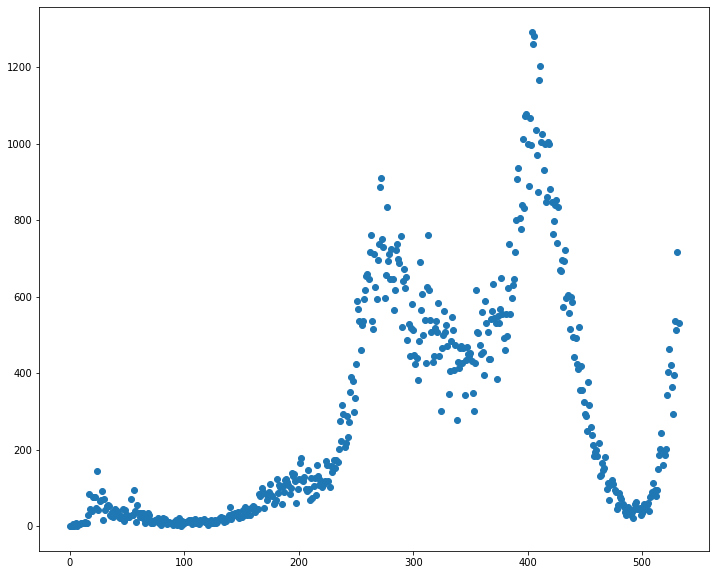

In [79]:
plt.figure(figsize=(12,10))
plt.scatter(X['Date'], Y)


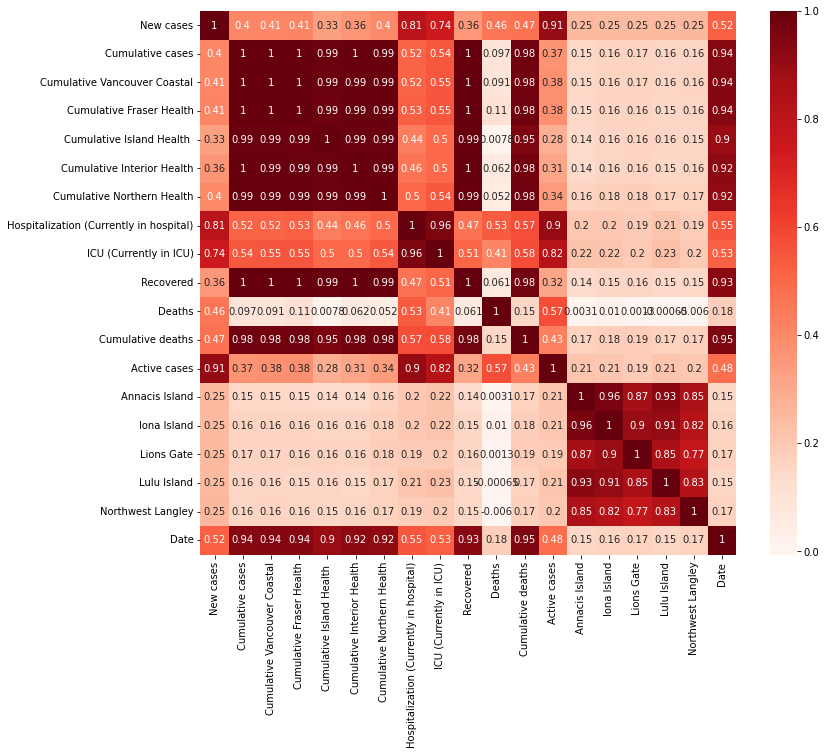

'\nNote: The commulative hospital cases are highly correlated.\n'

In [4]:
"""
Lets do a descriptive analysis of the data.
"""
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

"""
Note: The commulative hospital cases are highly correlated.
"""


'\nWe see again that many of the predicators are still highly correlated. Cummulative predictors show a pattern that\ntracks the response. These could be fitted well with a polynomial. The other predictors show heteroskidacity, and\ncould be transformed through a log or square root. Overall the data is so far not good for a linear relationship.\n'

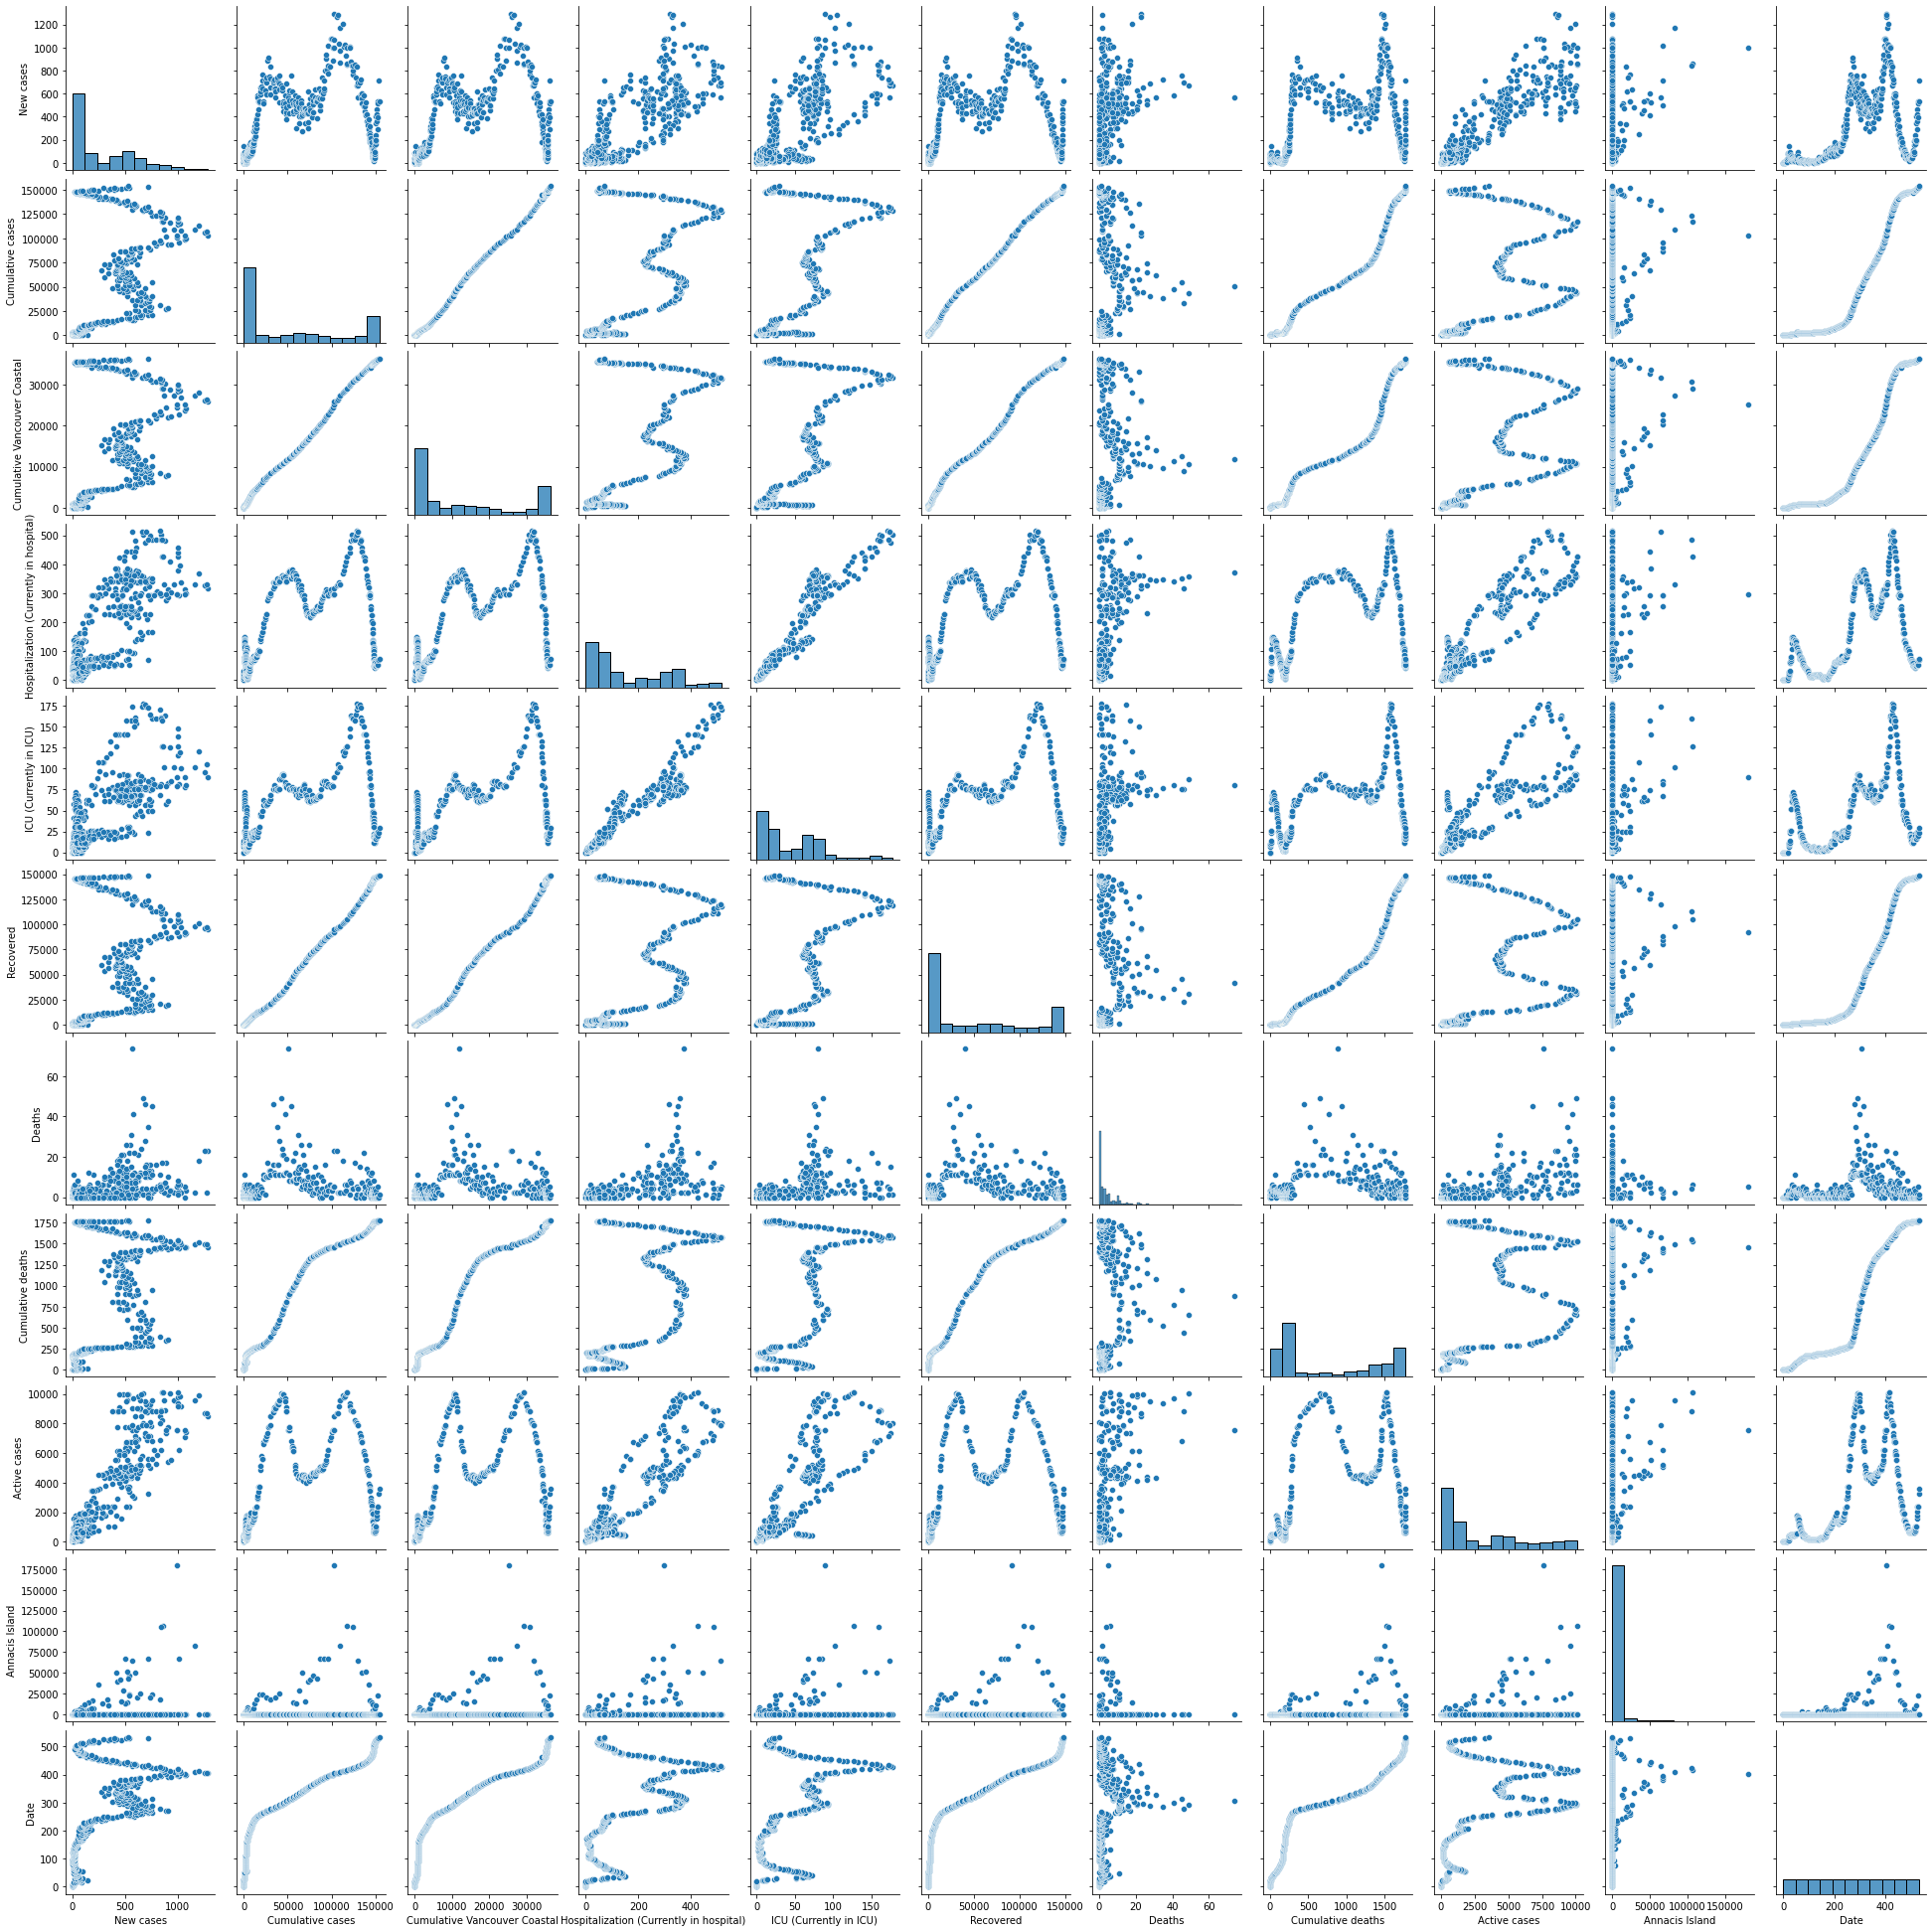

In [5]:

"""
Lets remove some of the redundant features to make the pairplt more managable.
These hhave the same relationship with eachother and the response.
"""
_X = X.drop(['Cumulative Fraser Health',
            'Cumulative Island Health ',
            'Cumulative Interior Health',
            'Cumulative Northern Health',
            'Iona Island', 
            'Lions Gate', 
            'Lulu Island',
            'Northwest Langley'
            ], axis=1)
sns.pairplot(_X)

"""
We see again that many of the predicators are still highly correlated. Cummulative predictors show a pattern that
tracks the response. These could be fitted well with a polynomial. The other predictors show heteroskidacity, and
could be transformed through a log or square root. Overall the data is so far not good for a linear relationship.
"""

In [6]:
"""
Baseline linear model (use all features)
"""

X = X.drop(['New cases'], axis=1)
_Y = Y

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)


81.80225568019296


In [7]:
"""
Cummulative predictors still help the linear relationship.
"""
_X = X.drop(['Cumulative Fraser Health',
    'Cumulative Island Health ',
    'Cumulative Interior Health',
    'Cumulative Northern Health',
    'Iona Island', 
    'Lions Gate', 
    'Lulu Island',
    'Northwest Langley',
    'Date'], axis=1)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, _X, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)


111.1186273190212


In [8]:
"""
Try transforming the predictors that show heteroskidacity.
"""
_X = X.copy()
features = [
    'Hospitalization (Currently in hospital)', 
    'ICU (Currently in ICU)',
    'Deaths',
    'Iona Island', 
    'Lions Gate', 
    'Lulu Island',
    'Northwest Langley'    
]
# _X[features] = _X[features].apply(np.sqrt)
_X[features] = _X[features] + 1
_X[features] = _X[features].apply(np.log)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, _X, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)
   

82.31935447489904


In [31]:
# Regularization
"""
Ridge Regression.
- Worse fit on the training data (but more generalizable to test data)
- Ridge regression decreases sensitivity through a penality
- Large alpha => greater penalty
- Good for small samples that result in bad least squares (bias)
- Works best when a lot of the variables are useful (Will shrink but not remove)
"""

_X = X.copy()
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = Ridge(alpha=0.99)
scores = cross_val_score(model, _X, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)

# Search for the best paramater (alpha)
_X = X.copy()
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = Ridge()
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = search.fit(_X, _Y)

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

81.80220409447551
MAE: -59.960
Config: {'alpha': 0.99}


In [29]:
"""
Lasso Regression
- Take abs of slope instead of squaring
- Still less sensitive to small training set
- Works well when you have a lot of useless variables (creates a simpler model)
"""
_X = X.copy()
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = Lasso(alpha=0.8)
scores = cross_val_score(model, _X, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)


91.18983403196847


73.01808762033203


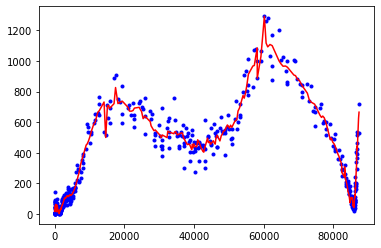

In [119]:
_X = X.copy()
_X = _X[['Cumulative cases', 
         'Cumulative Vancouver Coastal', 
         'Cumulative Fraser Health',
         'Cumulative Island Health ',
         'Cumulative Interior Health',
         'Cumulative Northern Health',
         'Cumulative deaths']]
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(_X)
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()

scores = cross_val_score(model, X_poly, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)

model.fit(X_poly,_Y)

# Plot
plt.plot(X['Cumulative Fraser Health'],_Y,"b.")
plt.plot(X_poly[:,3], model.predict(X_poly),'-r')
plt.show()



In [16]:
"""
Having the cummulative data causes issues for regression and pedicting the one day. Change it to daily.
"""


X_daily = X.copy()
df_diff = X_daily[['Cumulative Vancouver Coastal',
        'Cumulative Fraser Health',
        'Cumulative Island Health ',
        'Cumulative Interior Health',
        'Cumulative Northern Health',
        'Recovered'
        ]].diff()


df_diff.loc[0,'Cumulative Vancouver Coastal'] = 1
df_diff = df_diff.fillna(value=0)
# Zero negative values (corrections)
num = df._get_numeric_data()
num[num < 0] = 0

X_daily[['Cumulative Vancouver Coastal',
    'Cumulative Fraser Health',
    'Cumulative Island Health ',
    'Cumulative Interior Health',
    'Cumulative Northern Health',
    'Recovered']] = df_diff

X_daily = X_daily.drop(['New cases'], axis=1)
_Y = Y

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, X_daily, _Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

RMSE = np.sqrt(np.mean(np.absolute(scores)))
print(RMSE)

0        1.0
1        1.0
2        1.0
3        5.0
4        1.0
       ...  
528    395.0
529    536.0
530    513.0
531    717.0
532    532.0
Name: New cases, Length: 533, dtype: float64
102.63563569186385
